In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



price_col = 'd_ln_price'
# price_col = 'd_ln_joules_per_coin'

results_df = None

data_loc = '../6_calculating_costs/monthly_stuff.csv'

def get_data(filter1: str, filter2: str, averages=3):

    # date,price,hashrate,coins_per_block,efficiency,max_efficiency,speculation,adoption,altcoins,none,posts_count,positive,neutral,negative,optimistic_speculation,pessimistic_speculation
    # 2023-10-01,27978.1,4.4106749777492784e+20,6.25,23880028945.454502,,0.877076411960133,0.2043938991771647,0.127359781121751,0.3427030670711156,0.1050545094152626,0.3953488372093023,0.4418604651162791,0.1627906976744186,0.8024068322981367,0.2088509316770186
    data = pd.read_csv(data_loc, parse_dates=['date'])


    # keep only data after filter
    data = data[data['date'] >= filter1]
    data = data[data['date'] < filter2]

    # time variable
    # data['time'] = 2+((data['date'].dt.year - 2010) * 12 + data['date'].dt.month -2)
    # data['ln_time'] = np.log(data['time'])
    # data['time_squared'] = data['time']**2

    # # Create quarterly averages
    # quarterly_data = data.resample('Q', on='date').mean()

    # Resample the data to quarterly, ending the quarter in October
    quarterly_data = data.resample('Q-OCT', on='date').mean()


    # Create monthly averages
    monthly_data = data.resample('M', on='date').mean()
    # Create weekly averages
    weekly_data = data.resample('W', on='date').mean()
    # Keep daily data
    daily_data = data

    useful_cols = data.columns[1:]

    # for df in [quarterly_data,monthly_data, weekly_data, daily_data]:
    # for df in [quarterly_data]:
    for df in [quarterly_data,monthly_data]:
        df["date"] = df.index
        df["before_asic"] = np.zeros(len(df))
        df["before_gpu"] = np.zeros(len(df))
        for i in range(len(df)):
            if df["date"].iloc[i] < pd.Timestamp('2013-07-01'):
                df["before_asic"].iloc[i] = 1
            if df["date"].iloc[i] < pd.Timestamp('2012-07-01'):
                df["before_gpu"].iloc[i] = 1

        for column in useful_cols:
            # df[f'ln_{column}'] = np.log(df[column])
            df[f'd_ln_{column}'] = np.log(df[column]).diff().fillna(method='bfill')
            df[f'avg_d_ln_{column}'] = df[f'd_ln_{column}']
        df['ln_price'] = np.log(df['price'])
            

        # to prevent the arima model from cheating the values have to be shifted
        # for column in df.columns:
        #     if column.startswith('d_') and column != 'd_ln_open_price':
        #         df[column] = df[column].shift(-1).fillna(method='ffill')

    
        # to prevent the arima model from cheating the values are replaced with the average of the last 3
        for column in useful_cols:
            column2 = f'd_ln_{column}'
            if column2 != price_col:
                # print(column2)
                for i in range(len(df)):
                    offset = min(i, averages)
                    newval = df[column2].iloc[i-offset:i].mean()
                    df['avg_' + column2].iloc[i] = newval if not np.isnan(newval) else 0

        # calculate a prediction for joules_per_coin using the average of the last 3 d_ln values of hashrate and efficiency
        # coins_per_block is trivial to predict and can be taken from the data

        # df['predicted_hashrate'] = np.exp(np.log(df['hashrate'].shift(-1)) + df['avg_d_ln_hashrate'])
        # df['predicted_efficiency'] = np.exp(np.log(df['efficiency'].shift(-1)) + df['avg_d_ln_efficiency'])
        # df['predicted_coins_per_block'] = df['coins_per_block']  # Assuming this is directly taken from the data
        # df['predicted_joules_per_coin'] = df['predicted_hashrate'] / (df['predicted_efficiency'] * df['predicted_coins_per_block'])
        # df['d_ln_predicted_joules_per_coin'] = np.log(df['predicted_joules_per_coin']).diff().fillna(method='bfill')

        df['predicted_hashrate'] = np.zeros(len(df))
        df['predicted_efficiency'] = np.zeros(len(df))
        df['predicted_coins_per_block'] = np.zeros(len(df))
        df['predicted_joules_per_coin'] = np.zeros(len(df))
        df['d_ln_predicted_joules_per_coin'] = np.zeros(len(df))
        for i in range(len(df)):
            # for the first value, we give the model the real value instead of a prediction
            if i == 0:
                df['predicted_hashrate'].iloc[i] = df['hashrate'].iloc[i]
                df['predicted_efficiency'].iloc[i] = df['efficiency'].iloc[i]
                df['predicted_coins_per_block'].iloc[i] = df['coins_per_block'].iloc[i]
                df['predicted_joules_per_coin'].iloc[i] = df['hashrate'].iloc[i] / (df['efficiency'].iloc[i] * df['coins_per_block'].iloc[i])
            else:
                df['predicted_hashrate'].iloc[i] = np.exp(np.log(df['hashrate'].iloc[i-1]) + df['avg_d_ln_hashrate'].iloc[i])
                df['predicted_efficiency'].iloc[i] = np.exp(np.log(df['efficiency'].iloc[i-1]) + df['avg_d_ln_efficiency'].iloc[i])
                df['predicted_coins_per_block'].iloc[i] = df['coins_per_block'].iloc[i]
                df['predicted_joules_per_coin'].iloc[i] = df['predicted_hashrate'].iloc[i] / (df['predicted_efficiency'].iloc[i] * df['predicted_coins_per_block'].iloc[i])

        df['d_ln_predicted_joules_per_coin'] = np.log(df['predicted_joules_per_coin']).diff().fillna(method='bfill')

        df['real_joules_per_coin'] = df['hashrate'] / (df['efficiency'] * df['coins_per_block'])
        df['ln_real_joules_per_coin'] = np.log(df['real_joules_per_coin'])
        df['ln_joules_per_coin'] = np.log(df['real_joules_per_coin'])
        df['d_ln_joules_per_coin'] = np.log(df['real_joules_per_coin']).diff().fillna(method='bfill')

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='bfill', inplace=True)

        # to_scale = []
        # for column in df.columns:
        #     if column.startswith('d_') and column != price_col:
        #         to_scale.append(column)
        # for column in to_scale:
        #     scaler = MinMaxScaler()
        #     df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))


    return quarterly_data,monthly_data, weekly_data, daily_data







def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    # scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    # normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency', 'cost', 'open_price', 'd_ln_cost', 'd_ln_joules_per_coin']])
    # normalized_count = normalized_values[:, 0]
    # normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    # normalized_cost = normalized_values[:, 2]
    # normalized_open_price = normalized_values[:, 3]
    # normalized_d_ln_cost = normalized_values[:, 4]
    # normalized_d_ln_joules_per_coin = normalized_values[:, 5]

    offset = -9 if price_col == 'ln_open_price' else 0
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data[price_col]+offset, label=f'Actual {price_col}', color='blue', marker='o')
    plt.scatter(test_data.index, predictions+offset, label=f'Predicted {price_col}', color='red', marker='x')
    # plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_joules_per_coin, label='Normalized normalized_d_ln_joules_per_coin', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    # plt.plot(test_data.index, normalized_d_ln_cost, label='Normalized d_ln_cost', color='purple', linestyle='-.')
    # plt.plot(test_data.index, normalized_cost, label='Normalized Cost', color='orange', linestyle=':')
    # plt.plot(test_data.index, normalized_open_price, label='Normalized Open Price', color='black', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def residuals_tests(model_fit):
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = [-1,-1]
    try:
        white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    except Exception as e:
        pass
    
    res = {
        'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }
    for k, v in res.items():
        print(k + ": " + str(v)[:(5 if k not in ['White Test'] else 9)])

loss_table = []
full_model = None
# Adjust the model estimation to use the differenced series
def model_estimation(data, p_range, q_range, exog_cols, use_exog, title='Model Estimation', eval_size=8, noprint=False):
    global results_df
    global loss_table 
    global full_model

    results = []
    data_size = len(data)
    train_size = data_size - eval_size

    loss_table = []

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                rolling_mse = []
                mean_baseline_mae = []
                mean_baseline_mse = []
                prev_value_baseline_mae = []
                prev_value_baseline_mse = []
                step_size = 1
                summary = ""
                all_predictions = []
                for end in range(train_size, data_size, step_size):  # Adjust these values as needed
                    # print(f"p: {p}, q: {q}, end: {end}")
                    rolling_train = data.iloc[0:end]
                    rolling_test = data.iloc[end:end + step_size]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[exog_cols], rolling_test[exog_cols])
                    
                    # Baseline 1: Mean Prediction
                    mean_pred = np.mean(rolling_train[price_col])
                    mean_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [mean_pred]*step_size))
                    mean_baseline_mse.append(mean_squared_error(rolling_test[price_col], [mean_pred]*step_size))
                    
                    # Baseline 2: Previous Value Prediction
                    prev_value_pred = rolling_train[price_col].iloc[-1]
                    prev_value_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [prev_value_pred]*step_size))
                    prev_value_baseline_mse.append(mean_squared_error(rolling_test[price_col], [prev_value_pred]*step_size))


                    # ARIMA Model
                    if use_exog:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q), exog=rolling_train_exog)
                    else:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q))
                    model_fit = model.fit()
                    
                    summary = model_fit.summary()
                    if use_exog:
                        predictions = model_fit.forecast(steps=step_size, exog=rolling_test_exog)
                    else:
                        predictions = model_fit.forecast(steps=step_size)
                    mae = mean_absolute_error(rolling_test[price_col], predictions)
                    mse = mean_squared_error(rolling_test[price_col], predictions)
                    rolling_mae.append(mae)
                    rolling_mse.append(mse)
                    all_predictions.extend(predictions)
                
                # print("rolling_mse")
                # print(rolling_mse)
                avg_mae = np.mean(rolling_mae)
                avg_mse = np.mean(rolling_mse)
                avg_mean_baseline_mae = np.mean(mean_baseline_mae)
                avg_mean_baseline_mse = np.mean(mean_baseline_mse)
                avg_prev_value_baseline_mae = np.mean(prev_value_baseline_mae)
                avg_prev_value_baseline_mse = np.mean(prev_value_baseline_mse)
                results.append({'p': p, 'q': q, 'MAE': avg_mae, 'Mean Baseline MAE': avg_mean_baseline_mae, 'Prev Value Baseline MAE': avg_prev_value_baseline_mae, 'MSE': avg_mse, 'Mean Baseline MSE': avg_mean_baseline_mse, 'Prev Value Baseline MSE': avg_prev_value_baseline_mse,'Summary': summary,'all_predictions':all_predictions})

                loss_table.append({"p":p,"q":q,"MSE":avg_mse,"MAE":avg_mae})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")
                if noprint:
                    return 9999

    if noprint:
        return results[0]['MSE']

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MSE'])
    print(f"Mean Baseline MSE: {results[0]['Mean Baseline MSE']}")
    print(f"Previous Value Baseline MSE: {results[0]['Prev Value Baseline MSE']}")
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        
        # Fit the model on the entire training dataset
        model_fit = None
        if use_exog:
            train_exog, _ = add_constant(data[exog_cols], [])
            train_exog = np.array(train_exog)
            model = ARIMA(data[price_col], order=(p, 0, q), exog=train_exog)
            model_fit = model.fit()
        else:
            model = ARIMA(data[price_col], order=(p, 0, q))
            model_fit = model.fit()

        full_model = model_fit

        print(f"Top {i+1} Model: ARIMA({p},0,{q})")
        residuals_tests(model_fit)
        print("MSE:",results[i]['MSE'])
        print(results[i]['Summary'])

        train_data = data.iloc[0:train_size]
        test_data = data.iloc[train_size:]

        all_predictions = results[i]['all_predictions']
        all_predictions_with_dates = pd.Series(all_predictions, index=test_data.index)

        all_predictions_with_dates_df = pd.DataFrame(all_predictions_with_dates, columns=['predicted_d_ln_price'])
        all_predictions_with_dates_df.to_csv(f'predictions_{title}_{p}_{q}.csv')

        # plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")
        plot_model(test_data, all_predictions_with_dates, p, q, title=f"{title} - Top {i+1} Model")



In [11]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    cols = [price_col,'d_ln_joules_per_coin'] #'d_ln_avg_efficiency', 
    numeric_df = df[cols]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # rename count to "amount of values"
    summary.rename(columns={'count': 'amount of values'}, inplace=True)
    # print(summary)

    for col in cols:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=10, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=10, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
    from arch.unitroot import DFGLS
    
    # Augmented Dickey-Fuller Test
    adf_result = adfuller(series.dropna())
    print('Augmented Dickey-Fuller Test:')
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')
    
    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c')
    print('KPSS Test:')
    print('KPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')
    
    # Phillips-Perron Test
    # pp_result = phillips_perron(series.dropna())
    # print('Phillips-Perron Test:')
    # print('PP Statistic: %f' % pp_result.stat)
    # print('p-value: %f' % pp_result.pvalue)
    # print('Critical Values:')
    # for key, value in pp_result.critical_values.items():
    #     print('\t%s: %.3f' % (key, value))
    # print('\n')
    
    # Zivot-Andrews Test
    # za_result = zivot_andrews(series.dropna(), maxlag=12)
    # print('Zivot-Andrews Test:')
    # print('ZA Statistic: %f' % za_result[0])
    # print('p-value: %f' % za_result[1])
    # print('Critical Values:')
    # for key, value in za_result[2].items():
    #     print('\t%s: %.3f' % (key, value))
    # print('\n')
    
    # Elliott-Rothenberg-Stock (ERS) Test
    ers_result = DFGLS(series.dropna())
    print('Elliott-Rothenberg-Stock (ERS) Test:')
    print('ERS Statistic: %f' % ers_result.stat)
    print('p-value: %f' % ers_result.pvalue)
    print('Critical Values:')
    for key, value in ers_result.critical_values.items():
        print('\t%s: %.3f' % (key, value))
    print('\n')


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    print("")
    # return score, p_value, crit_value


def cross_correlation(series1, series2, lag=10, plot=True):
    """
    Calculate and plot cross-correlation between two series.
    
    Parameters:
    - series1: First time series.
    - series2: Second time series.
    - lag: Number of lags to calculate cross-correlation for.
    - plot: Whether to plot the cross-correlation values.
    
    Returns:
    - Cross-correlation values.
    """
    cc_values = [series1.corr(series2.shift(l)) for l in range(-lag, lag+1)]
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.stem(range(-lag, lag+1), cc_values)#, use_line_collection=True)
        plt.xlabel('Lag')
        plt.ylabel('Cross-correlation')
        plt.title('Cross-correlation between series')
        plt.show()
    
    return cc_values

In [12]:
# quarterly_data, monthly_data, weekly_data, daily_data = get_data('2010-12-31', '9999-01-01',2)
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2011-08-15', '9999-01-01',2)
# quarterly_data, monthly_data, weekly_data, daily_data = get_data('2013-07-01', '9999-01-01',2)
# quarterly_data, monthly_data, weekly_data, daily_data = get_data('2005-12-31', '9999-01-01',2)

In [13]:
quarterly_data.head(10)

,price,hashrate,coins_per_block,efficiency,max_efficiency,speculation,adoption,altcoins,none,posts_count,positive,neutral,negative,optimistic_speculation,pessimistic_speculation,date,before_asic,before_gpu,d_ln_price,avg_d_ln_price,d_ln_hashrate,avg_d_ln_hashrate,d_ln_coins_per_block,avg_d_ln_coins_per_block,d_ln_efficiency,avg_d_ln_efficiency,d_ln_max_efficiency,avg_d_ln_max_efficiency,d_ln_speculation,avg_d_ln_speculation,d_ln_adoption,avg_d_ln_adoption,d_ln_altcoins,avg_d_ln_altcoins,d_ln_none,avg_d_ln_none,d_ln_posts_count,avg_d_ln_posts_count,d_ln_positive,avg_d_ln_positive,d_ln_neutral,avg_d_ln_neutral,d_ln_negative,avg_d_ln_negative,d_ln_optimistic_speculation,avg_d_ln_optimistic_speculation,d_ln_pessimistic_speculation,avg_d_ln_pessimistic_speculation,ln_price,predicted_hashrate,predicted_efficiency,predicted_coins_per_block,predicted_joules_per_coin,d_ln_predicted_joules_per_coin,real_joules_per_coin,ln_real_joules_per_coin,ln_joules_per_coin,d_ln_joules_per_coin
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-31,8.779000,1.150394e+13,50.000000,1.743411e+06,0.000018,0.222726,0.235390,0.134037,0.843249,0.218038,0.290211,0.550657,0.159132,0.148404,0.194057,2011-10-31,1.0,1.0,-0.830569,-0.830569,-0.273331,0.000000,-0.016807,0.000000,0.318451,0.000000,0.278687,0.000000,-0.399908,0.000000,0.530798,0.000000,-0.484093,0.000000,-0.205664,0.000000,-0.738081,0.000000,0.156897,0.000000,-0.023948,0.000000,-0.258667,0.000000,-0.646105,0.000000,-1.419127,0.000000,2.172363,1.150394e+13,1.743411e+06,50.000000,131970.511206,-0.574975,131970.511206,11.790334,11.790334,-0.574975
2012-01-31,3.825900,8.752667e+12,49.166667,2.397184e+06,0.000023,0.149311,0.400231,0.082601,0.686495,0.104229,0.339511,0.537626,0.122863,0.077776,0.046947,2012-01-31,1.0,1.0,-0.830569,-0.830569,-0.273331,-0.273331,-0.016807,-0.016807,0.318451,0.318451,0.278687,0.278687,-0.399908,-0.399908,0.530798,0.530798,-0.484093,-0.484093,-0.205664,-0.205664,-0.738081,-0.738081,0.156897,0.156897,-0.023948,-0.023948,-0.258667,-0.258667,-0.646105,-0.646105,-1.419127,-1.419127,1.341794,8.752667e+12,2.397184e+06,49.166667,74262.275435,-0.574975,74262.275435,11.215358,11.215358,-0.574975
2012-04-30,5.274633,1.097600e+13,25.000000,4.231405e+06,0.000023,0.154532,0.425531,0.050577,0.652909,0.095970,0.306082,0.585518,0.108400,0.066894,0.045195,2012-04-30,1.0,1.0,0.321115,0.321115,0.226353,-0.273331,-0.676340,-0.016807,0.568239,0.318451,0.000000,0.278687,0.034366,-0.399908,0.061296,0.530798,-0.490523,-0.484093,-0.050161,-0.205664,-0.082555,-0.738081,-0.103653,0.156897,0.085333,-0.023948,-0.125236,-0.258667,-0.150721,-0.646105,-0.038041,-1.419127,1.662909,6.659386e+12,3.296120e+06,25.000000,80814.841108,0.084558,103757.488933,11.549812,11.549812,0.334453
2012-07-31,5.634600,1.248052e+13,25.000000,4.135115e+06,0.000023,0.090833,0.399623,0.039094,0.743531,0.113148,0.288016,0.621071,0.090913,0.080822,0.010614,2012-07-31,1.0,0.0,0.066017,0.066017,0.128458,-0.023489,0.000000,-0.346574,-0.023019,0.443345,0.000000,0.139343,-0.531380,-0.182771,-0.062815,0.296047,-0.257529,-0.487308,0.129973,-0.127913,0.164668,-0.410318,-0.060836,0.026622,0.058949,0.030692,-0.175929,-0.191951,0.189132,-0.398413,-1.448815,-0.728584,1.728926,1.072119e+13,6.592151e+06,25.000000,65054.258599,-0.216939,120727.143026,11.701288,11.701288,0.151477
2012-10-31,10.638567,2.022424e+13,25.000000,5.321771e+06,0.000023,0.183522,0.387945,0.034058,0.683364,0.088537,0.263496,0.609672,0.126832,0.071286,0.074886,2012-10-31,1.0,0.0,0.635560,0.635560,0.482713,0.177405,0.000000,-0.338170,0.252291,0.272610,0.000000,0.000000,0.703312,-0.248507,-0.029659,-0.000760,-0.137920,-0.374026,-0.084383,0.039906,-0.245285,0.041056,-0.088980,-0.082245,-0.018524,0.072141,0.332963,-0.150582,-0.125548,0.019205,1.953793,-0.743428,2.364486,1.490317e+13,5.431011e+06,25.000000,109763.483222,0.523106,152011.380643,11.931711,11.931711,0.230422
2013-01-31,12.145367,2.312333e+13,25.000000,4.109668e+07,0.000363,0.088007,0.447272,0.03083

In [14]:
quarterly_data.tail(15)

# quarterly_data

,price,hashrate,coins_per_block,efficiency,max_efficiency,speculation,adoption,altcoins,none,posts_count,positive,neutral,negative,optimistic_speculation,pessimistic_speculation,date,before_asic,before_gpu,d_ln_price,avg_d_ln_price,d_ln_hashrate,avg_d_ln_hashrate,d_ln_coins_per_block,avg_d_ln_coins_per_block,d_ln_efficiency,avg_d_ln_efficiency,d_ln_max_efficiency,avg_d_ln_max_efficiency,d_ln_speculation,avg_d_ln_speculation,d_ln_adoption,avg_d_ln_adoption,d_ln_altcoins,avg_d_ln_altcoins,d_ln_none,avg_d_ln_none,d_ln_posts_count,avg_d_ln_posts_count,d_ln_positive,avg_d_ln_positive,d_ln_neutral,avg_d_ln_neutral,d_ln_negative,avg_d_ln_negative,d_ln_optimistic_speculation,avg_d_ln_optimistic_speculation,d_ln_pessimistic_speculation,avg_d_ln_pessimistic_speculation,ln_price,predicted_hashrate,predicted_efficiency,predicted_coins_per_block,predicted_joules_per_coin,d_ln_predicted_joules_per_coin,real_joules_per_coin,ln_real_joules_per_coin,ln_joules_per_coin,d_ln_joules_per_coin
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-30,8180.632341,1.098500e+20,12.500,1.377711e+10,0.028999,0.748168,0.209081,0.080381,0.451648,0.081269,0.375132,0.441206,0.183662,0.596401,0.508549,2020-04-30,0.0,0.0,0.028310,0.028310,0.105007,0.266173,0.000000,0.000000,0.064381,0.143715,0.136454,0.000000,0.094129,0.092276,-0.317420,-0.009755,-0.925766,-0.348858,0.175763,-0.064474,-0.298296,-0.104432,0.092103,0.027325,-0.119772,-0.000746,0.134614,-0.047668,0.121429,0.016264,0.742825,0.033357,9.009525,1.290606e+20,1.491463e+10,12.500,6.922628e+08,0.005993,6.378697e+08,20.273645,20.273645,0.040626
2020-07-31,9412.139922,1.113285e+20,6.875,1.561955e+10,0.033900,0.480281,0.257799,0.231586,0.581233,0.093327,0.260757,0.547459,0.191784,0.471036,0.275066,2020-07-31,0.0,0.0,0.140231,0.140231,0.013369,0.121369,-0.597837,0.000000,0.125515,0.058241,0.156156,0.068227,-0.443255,0.177591,0.209457,-0.145979,1.058172,-0.938282,0.252248,-0.012431,0.138347,-0.110758,-0.363689,0.080357,0.215774,-0.064830,0.043277,0.024878,-0.235979,0.190784,-0.614549,0.124534,9.149756,1.240252e+20,1.460333e+10,6.875,1.235336e+09,0.579133,1.036729e+09,20.759336,20.759336,0.485691
2020-10-31,11445.482704,1.316030e+20,6.250,1.422240e+10,0.033900,0.509671,0.358356,0.303752,0.405929,0.090519,0.328367,0.512545,0.159089,0.589917,0.201471,2020-10-31,0.0,0.0,0.195595,0.195595,0.167305,0.059188,-0.095310,-0.298919,-0.093705,0.094948,0.000000,0.146305,0.059394,-0.174563,0.329347,-0.053982,0.271261,0.066203,-0.358973,0.214006,-0.030550,-0.079975,0.230542,-0.135793,-0.065899,0.048001,-0.186910,0.088946,0.225048,-0.057275,-0.311365,0.064138,9.345350,1.181167e+20,1.717528e+10,6.250,1.100341e+09,-0.115723,1.480516e+09,21.115656,21.115656,0.356320
2021-01-31,20630.080511,1.395333e+20,6.250,1.345953e+10,0.033900,0.917308,0.143460,0.220420,0.376900,0.158242,0.344642,0.491747,0.163611,0.897617,0.399676,2021-01-31,0.0,0.0,0.589155,0.589155,0.058513,0.090337,0.000000,-0.346574,-0.055131,0.015905,0.000000,0.078078,0.587677,-0.191931,-0.915471,0.269402,-0.320676,0.664716,-0.074197,-0.053362,0.558572,0.053898,0.048375,-0.066574,-0.041423,0.074938,0.028028,-0.071817,0.419761,-0.005466,0.685006,-0.462957,9.934506,1.440452e+20,1.445041e+10,6.250,1.594918e+09,0.371202,1.658701e+09,21.229301,21.229301,0.113644
2021-04-30,47275.664410,1.585333e+20,6.250,1.340937e+10,0.033900,0.694866,0.282566,0.201773,0.373828,0.104559,0.374007,0.463810,0.160499,0.750214,0.470530,2021-04-30,0.0,0.0,0.829245,0.829245,0.127661,0.112909,0.000000,-0.047655,-0.003734,-0.074418,0.000000,0.000000,-0.277724,0.323536,0.677857,-0.293062,-0.088391,-0.024708,-0.008184,-0.216585,-0.414377,0.264011,0.081769,0.139459,-0.058490,-0.053661,-0.019199,-0.079441,-0.179385,0.322404,0.163206,0.186821,10.763751,1.562118e+20,1.249426e+10,6.250,2.000429e+09,0.226539,1.891613e+09,21.360696,21.360696,0.131395
2021-07-31,42676.192956,1.264633e+20,6.250,1.545912e+10,0.033900,0.641997,0.367755,0.136669,0.311925,0.099273,0.341167,0.484800,0.172511,0.6067

In [15]:
# for col in quarterly_data.columns:
#     if col.startswith('avg'):
#         print(f"# '{col}',")s

In [16]:

# # find best start date
# dates = pd.read_csv(data_loc, parse_dates=['date']).resample('Q', on='date').mean().index
# dates = dates[:33]
# best_mse = 999999
# best_date = None
# best_averaging = None
# for date in dates:
#     print(date)
#     for averaging in [2,3]:
#         print(averaging)
#         quarterly_data, monthly_data, weekly_data, daily_data = get_data(date, '9999-01-01',averaging)
#         all_mse = []
#         for cols in [[],['d_ln_joules_per_coin'],['avg_d_ln_pessimistic_speculation']]:
#             mse = model_estimation(quarterly_data, range(1, 2, 1), range(1, 2, 1), cols, True, title='Quarterly Data', eval_size=13, noprint=True)
#             all_mse.append(mse)
#         print(np.mean(all_mse))
#         if np.mean(all_mse) < best_mse:
#             best_mse = np.mean(all_mse)
#             best_date = date
#             best_averaging = averaging

# print("")
# print(best_date)
# print(best_mse)
# print(best_averaging)
    

In [17]:
# d = monthly_data[["price","real_joules_per_coin"]]
# d["date"] = d.index
# d.to_csv("monthly_price_joules.csv",index=False)

# Quaterly

Quarterly Data Model Estimation:


Mean Baseline MSE: 0.1248180106924637
Previous Value Baseline MSE: 0.12958621015312988
Top 1 Model: ARIMA(1,0,1)
AIC: 66.75
BIC: 78.10
Ljung-Box: 0.361
Durbin-Watson: 1.981
Jarque-Bera: 0.847
Shapiro-Wilk: 0.324
White Test: 3.5044731
MSE: 0.09489613260853112
                               SARIMAX Results                                
Dep. Variable:             d_ln_price   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -27.286
Date:                Thu, 06 Jun 2024   AIC                             66.571
Time:                        13:49:26   BIC                             77.799
Sample:                    10-31-2011   HQIC                            70.814
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------

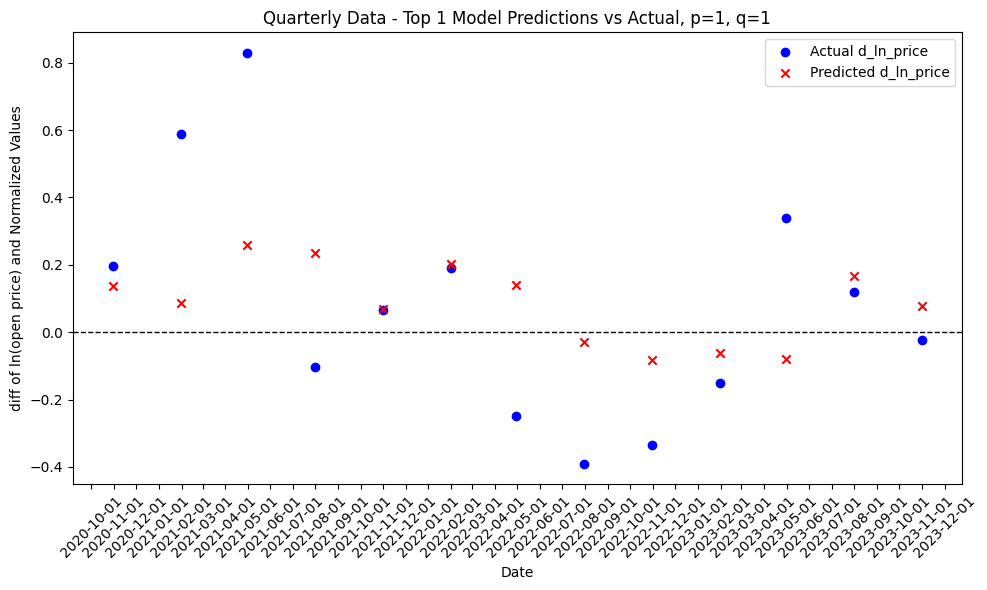

IndexError: list index out of range

In [18]:
exog_cols = [
'before_asic',
# 'before_gpu',

# 'd_ln_price',

# 'avg_efficiency',
# 'avg_d_ln_max_efficiency',
# 'avg_d_ln_count',
# 'avg_d_ln_cost_per_coin',
# 'avg_d_ln_watts',
# 'avg_d_ln_joules_per_dollar_earned',
# 'avg_d_ln_optimistic_speculation',

# 'd_ln_predicted_joules_per_coin',
'd_ln_joules_per_coin',
# 'ln_joules_per_coin',

# 'avg_d_ln_adoption',

# 'avg_d_ln_hashrate',
# 'avg_d_ln_efficiency',
# 'd_ln_efficiency',

# 'd_ln_pessimistic_speculation',

# 'avg_d_ln_pessimistic_speculation',
# 'avg_d_ln_speculation',
# 'avg_d_ln_posts_count',
# 'avg_d_ln_positive',
# 'avg_d_ln_neutral',
# 'avg_d_ln_negative',

# 'time',
# 'ln_time',
# 'time_squared',
]
# Baseline 3: no exog
# use_exog = False
use_exog = True

print("Quarterly Data Model Estimation:")
# model_estimation(quarterly_data, range(1, 5, 1), range(1, 5, 1), exog_cols, use_exog, title='Quarterly Data', eval_size=13)
model_estimation(quarterly_data, range(1, 2, 1), range(1, 2, 1), exog_cols, use_exog, title='Quarterly Data', eval_size=13)
results_df

In [24]:
# price model: run predictions on the full data
full_exog, _ = add_constant(quarterly_data[exog_cols], [])
predictions_full_data = full_model.predict(start=0, end=len(quarterly_data)-1, exog=full_exog)
predictions_full_data = pd.DataFrame(predictions_full_data)
# rename predicted_mean to predicted_d_ln_price
predictions_full_data.rename(columns={'predicted_mean': 'predicted_d_ln_price'}, inplace=True)
predictions_full_data

,predicted_d_ln_price
date,
2011-10-31,0.004927
2012-01-31,-0.283661
2012-04-30,-0.005877
2012-07-31,0.200482
2012-10-31,0.209833
2013-01-31,-0.345123
2013-04-30,0.536040
2013-07-31,0.238558
2013-10-31,0.957023


In [25]:
predictions_full_data.to_csv(f'predictions_full_data.csv')

In [ ]:
loss_table_df = pd.DataFrame(loss_table)
loss_table_df

,p,q,MSE,MAE
0,1,1,0.094896,0.241169
1,1,2,0.093545,0.259048
2,1,3,0.138386,0.311853
3,1,4,0.133385,0.311550
4,2,1,0.099896,0.248423
5,2,2,0.094563,0.267450
6,2,3,0.116980,0.299035
7,2,4,0.120708,0.305307
8,3,1,0.086711,0.246678
9,3,2,0.118437,0.296945


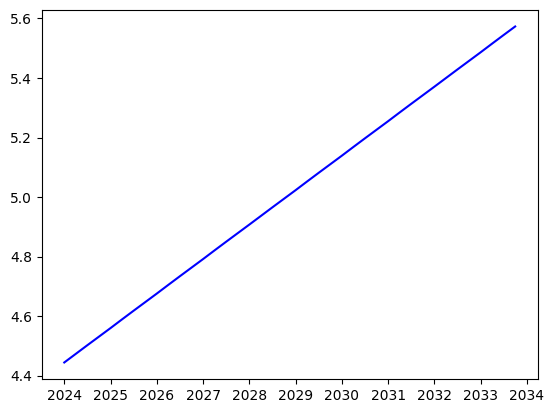

In [ ]:
# # obtain long term forecast
# exog = quarterly_data[cols]
# model = ARIMA(quarterly_data[price_col], order=(1, 0, 1), exog=exog).fit()
# # repeat the average of the last 10 rows for 10 years
# exog2 = pd.DataFrame()
# for column in cols:
#     exog2[column] = [quarterly_data[column].iloc[-10:].mean()]*40
# # print(exog2)
# preds = model.forecast(steps=40, exog=exog2)
# # print(preds)

# # plot the predicted price
# plt.figure(figsize=(10, 6))
# dates = pd.date_range(start=quarterly_data.index[-1], end='2033-11-01', freq='Q')

# last_price = quarterly_data["price"].iloc[-1]
# ln_prices = np.log(last_price) + preds.cumsum()
# prices = np.exp(ln_prices)
# log10_prices = np.log10(prices)

# plt.plot(dates, log10_prices, label='Predicted Price', color='red')



# obtain long term forecast with koomey's law
last_price = quarterly_data["price"].iloc[-1]
time_to_double = 2.6
koomey_preds = []
for i in range(40):
    koomey_preds.append(last_price * 2**((i/4)/time_to_double))
dates = pd.date_range(start=quarterly_data.index[-1], end='2033-11-01', freq='Q')
plt.plot(dates, np.log10(koomey_preds), label='Koomey Prediction', color='blue')

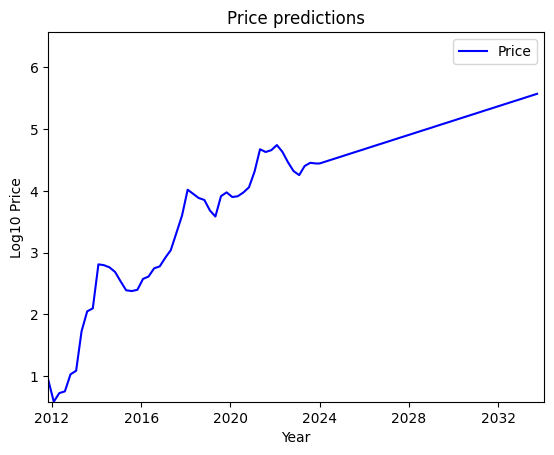

In [ ]:
# create plot with old data and prediction
# concat the x axis
old_x = quarterly_data.index
new_x = dates
all_x = np.concatenate([old_x,new_x])
# concat the y axis
old_y = np.log10(quarterly_data["price"])
new_y = np.log10(koomey_preds)
all_y = np.concatenate([old_y,new_y])

plt.plot(all_x, all_y, label='Price', color='blue')

# Get current axes
ax = plt.gca()

# Extend the limits of x and y axes
ax.set_xlim([min(all_x), max(all_x) + 9999999999999999])  # Extend x-axis to the right
ax.set_ylim([min(all_y), max(all_y) + 1])  # Extend y-axis upwards

# Add labels and title if necessary
plt.xlabel('Year')
plt.ylabel('Log10 Price')
plt.title('Price predictions')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
first = koomey_preds[0]
last = koomey_preds[-1]

print("percentage increase:",100*(last-first)/first)

percentage increase: 1245.434264405943


In [ ]:
print(f"Stationarity check for ln_price:")
check_stationarity(quarterly_data["ln_price"])
# print(f"Stationarity check for d_ln_price:")
# check_stationarity(quarterly_data["d_ln_price"])
print("\nStationarity check for ln_real_joules_per_coin:")
check_stationarity(quarterly_data['ln_real_joules_per_coin'])
# print("\nStationarity check for d_ln_joules_per_coin:")
# check_stationarity(quarterly_data['d_ln_joules_per_coin'])
# print("\nStationarity check for avg_d_ln_pessimistic_speculation:")
# check_stationarity(quarterly_data['avg_d_ln_pessimistic_speculation'])

Stationarity check for ln_price:
Augmented Dickey-Fuller Test:
ADF Statistic: -2.022253
p-value: 0.276902
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


KPSS Test:
KPSS Statistic: 0.996111
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


Elliott-Rothenberg-Stock (ERS) Test:
ERS Statistic: -0.491367
p-value: 0.526433
Critical Values:
	1%: -2.940
	5%: -2.310
	10%: -2.001



Stationarity check for ln_real_joules_per_coin:
Augmented Dickey-Fuller Test:
ADF Statistic: -3.622307
p-value: 0.005349
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


KPSS Test:
KPSS Statistic: 0.999804
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


Elliott-Rothenberg-Stock (ERS) Test:
ERS Statistic: -0.239813
p-value: 0.605307
Critical Values:
	1%: -2.940
	5%: -2.310
	10%: -2.001




In [ ]:
import pandas as pd

# Define the data
data = {
    "Time Series": ["Logarithmized Bitcoin Price", "Logarithmized Joules per Coin"],
    "KPSS Statistic": [0.996111, 0.999804],
    "p-value": [0.010000, 0.010000],
    "Critical Values": ["10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739", "10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739"]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

,Time Series,KPSS Statistic,p-value,Critical Values
0,Logarithmized Bitcoin Price,0.996111,0.01,"10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739"
1,Logarithmized Joules per Coin,0.999804,0.01,"10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739"


Distribution Plot:


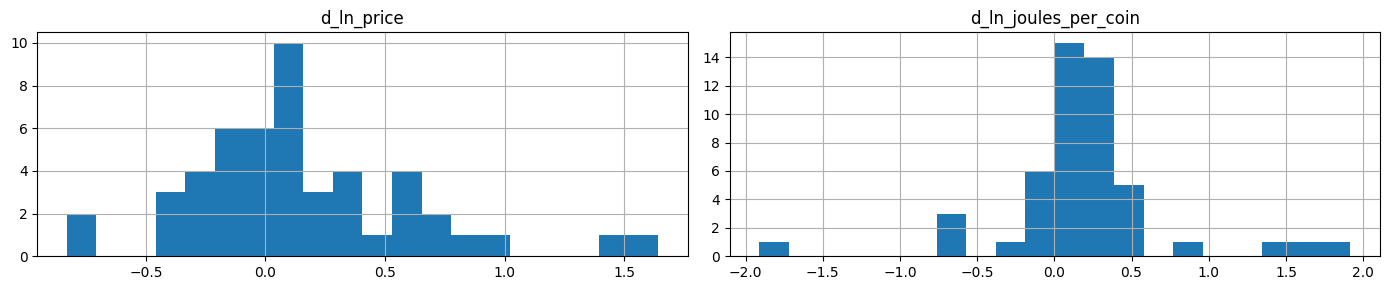

Summary Statistics:
ACF and PACF Plots for d_ln_price:


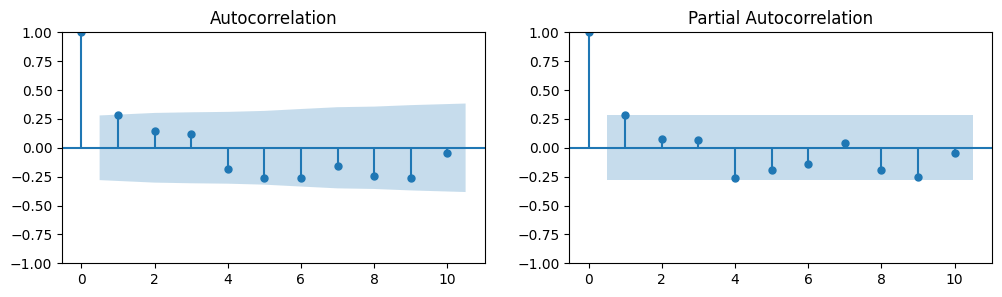

ACF and PACF Plots for d_ln_joules_per_coin:


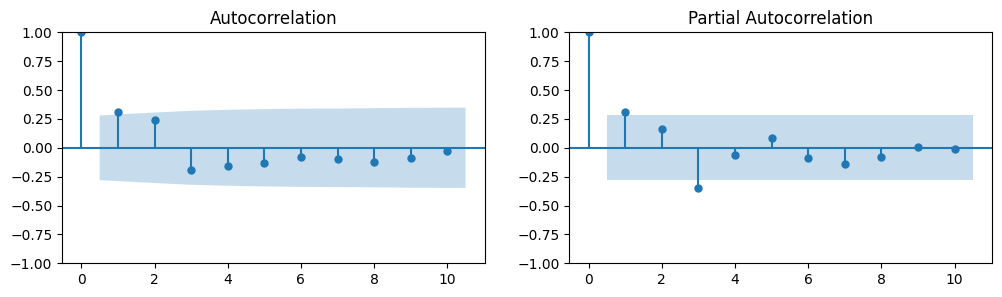

,amount of values,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_price,49.0,0.147554,0.484573,-0.830569,-0.150189,0.073323,0.326378,1.641406,0.878562,1.722494
d_ln_joules_per_coin,49.0,0.193376,0.553118,-1.910161,0.021412,0.159285,0.352006,1.917718,-0.122732,5.902435


In [ ]:
exploratory_analysis(quarterly_data)

In [ ]:
perform_cointegration_test(quarterly_data, price_col, 'd_ln_price')
perform_cointegration_test(quarterly_data, price_col, 'd_ln_joules_per_coin')

Co-integration test results for d_ln_price and d_ln_price:
t-statistic: -inf
p-value: 0.0
Critical values: [-4.13915623 -3.46638512 -3.13398889]
The series are likely co-integrated.

Co-integration test results for d_ln_price and d_ln_joules_per_coin:
t-statistic: -4.180155045566343
p-value: 0.003908592605301095
Critical values: [-4.13915623 -3.46638512 -3.13398889]
The series are likely co-integrated.



In [ ]:
# cross_correlation_values = cross_correlation(quarterly_data['d_ln_avg_efficiency'], quarterly_data[price_col], lag=10)

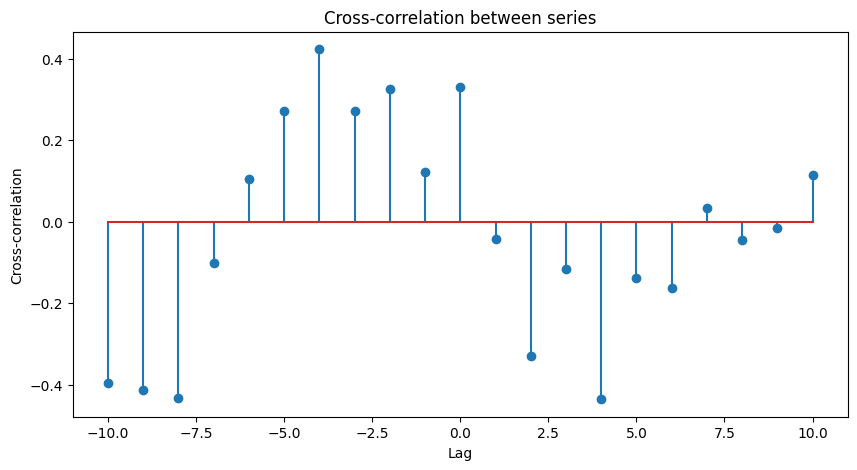

In [ ]:
# cross_correlation_values = cross_correlation(quarterly_data['d_ln_joules_per_coin'], quarterly_data['d_ln_price'], lag=10)
cross_correlation_values = cross_correlation(quarterly_data['d_ln_price'], quarterly_data['d_ln_joules_per_coin'], lag=10)

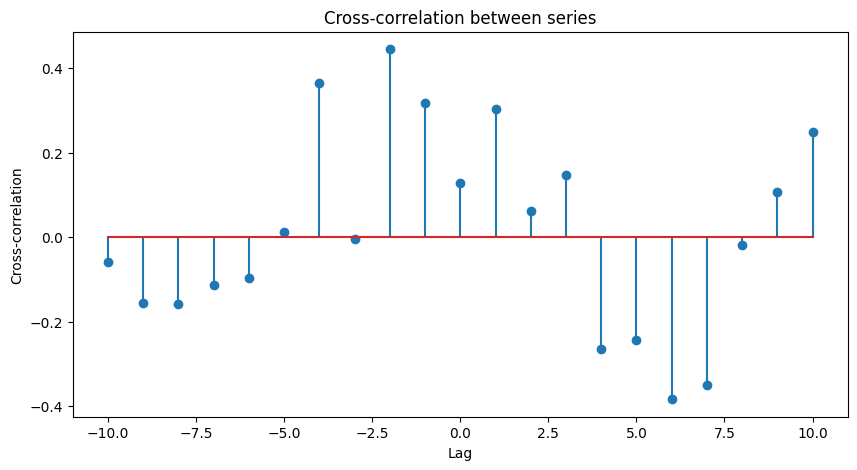

In [ ]:
cross_correlation_values = cross_correlation(quarterly_data['d_ln_efficiency'], quarterly_data['d_ln_price'], lag=10)

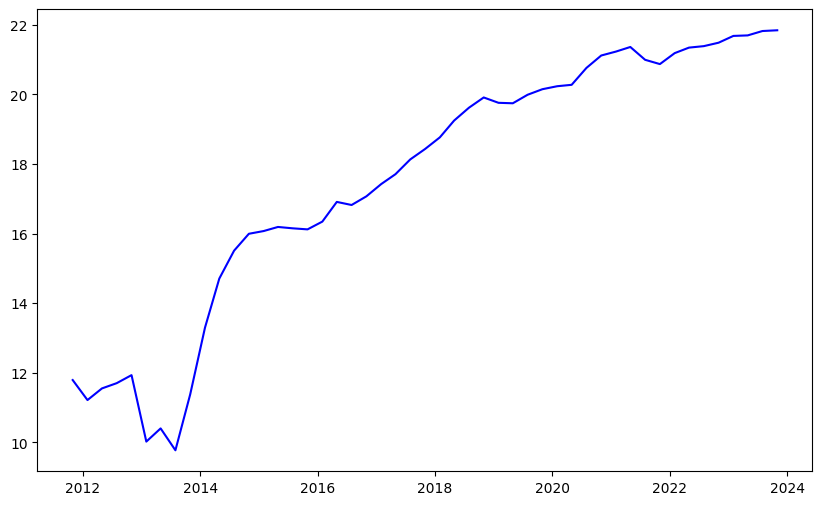

In [ ]:
# plot ln_real_joules_per_coin
plt.figure(figsize=(10, 6))
plt.plot(quarterly_data.index, quarterly_data['ln_real_joules_per_coin'], label='ln_real_joules_per_coin', color='blue')

# Monthly

In [ ]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(1, 6, 1), range(1, 6, 1), title='Monthly Data', eval_size=12)
results_df

Monthly Data Model Estimation:


TypeError: model_estimation() missing 2 required positional arguments: 'exog_cols' and 'use_exog'

In [ ]:
exploratory_analysis(monthly_data)

# Weekly

In [ ]:
print("Weekly Data Model Estimation:")
model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', eval_size=55)
# model_estimation(weekly_data, range(1, 4, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

In [ ]:
exploratory_analysis(weekly_data)

# Daily

In [ ]:
# print("Daily Data Model Estimation:")
# # model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
# model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

In [ ]:
exploratory_analysis(daily_data)